# Spatial Tx: ingest 10x Visium sample data
- Download sample data from https://cf.10xgenomics.com/samples/spatial-exp/2.1.0/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma
- Ingest into spatial SOMA
- Read from SOMA, inspect/plot data

**WARNING** _Spatial support is experimental and under active development. There will likely be breaking changes to both the storage format and API._

In [1]:
import shlex
from functools import partial
from os import makedirs, remove
from os.path import exists, join
from shutil import rmtree
from subprocess import check_call
from sys import stderr

import matplotlib.patches as mplp
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
from matplotlib.collections import PatchCollection

import tiledbsoma
from tiledbsoma import Experiment
from tiledbsoma.io.spatial import from_visium

err = partial(print, file=stderr)


/home/jules/.pyenv/versions/3.12.7/envs/soma/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


[Papermill](https://papermill.readthedocs.io/en/latest/) parameters:

In [2]:
# 10x visium sample data paths to download; will be skipped if already present locally, unless `overwrite`
url_base = 'https://cf.10xgenomics.com/samples/spatial-exp/2.1.0'
dataset_name = 'CytAssist_FFPE_Protein_Expression_Human_Glioblastoma'
filtered_h5 = 'CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_filtered_feature_bc_matrix.h5'
spatial_tar = 'CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_spatial.tar.gz'

# Local download/ingestion paths/configs:
data_root = 'data'     # Sync 10x Visium spatial data into f"{data_root}/{dataset_name}/10x". By default, spatial SOMA data will be ingested into f"{data_root}/{dataset_name}/soma" as well.
exp_uri = None         # Ingest spatial SOMA data here; defaults to f"{data_root}/{dataset_name}/soma"
scene_name = "scene1"  # Scene name to write, in ingested spatial SOMA
overwrite_10x = False  # If  already exists, remove and re-ingest it
overwrite_exp = False  # If `exp_uri` already exists, remove and re-ingest it

In [3]:
# Set default paths
dataset_root = join(data_root, dataset_name)
data_dir_10x = join(dataset_root, '10x')
if exp_uri is None:
    exp_uri = join(dataset_root, 'soma')
exp_uri

'data/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/soma'

In [4]:
def sh(*cmd):
    err(f"Running: {shlex.join(cmd)}")
    check_call(cmd)

## Download sample data from 10x
This section will download data from 10x and use that data to generate the TileDB-SOMA `Experiment` with spatial data.

In [5]:
if exists(exp_uri):
    if overwrite_exp:
        err(f"Removing {exp_uri}")
        rmtree(exp_uri)

In [6]:
paths = {
    filtered_h5: 'filtered_feature_bc_matrix.h5',
    spatial_tar: spatial_tar
}
if exists(exp_uri):
    err(f"{exp_uri} exists; skipping 10x data download")
else:
    for src_name, dst_name in paths.items():
        src = f'{url_base}/{dataset_name}/{src_name}'
        dst = join(data_dir_10x, dst_name)
        if exists(dst):
            if overwrite_10x:
                err(f"{dst} exists, removing")
                remove(dst)
        if not exists(dst):
            makedirs(data_dir_10x, exist_ok=True)
            sh('wget', '-qO', dst, src)
            if dst.endswith('.tar.gz'):
                sh('tar', '-C', data_dir_10x, '-xvf', dst)

data/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/soma exists; skipping 10x data download


In [7]:
if not exists(exp_uri):
    err(f"Ingesting {data_dir_10x} to {exp_uri}")
    from_visium(
        exp_uri,
        input_path=data_dir_10x,
        measurement_name="RNA",
        scene_name=scene_name,
        use_raw_counts=False,
    )

## Data access

Spatial SOMA experiments can be acess and queries using any of `tiledbsoma`'s exsiting APIs.

In [8]:
exp = Experiment.open(exp_uri)
exp.spatial

<Collection 'file:///home/jules/Software/TileDB-Inc/TileDB-SOMA/apis/python/notebooks/data/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/soma/spatial' (open for 'r') (1 item)
    'scene1': 'file:///home/jules/Software/TileDB-Inc/TileDB-SOMA/apis/python/notebooks/data/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/soma/spatial/scene1' (unopened)>

Here, we're loading the non-spatial elements into memory as a standard AnnData object.

In [9]:
adata = tiledbsoma.io.to_anndata(
    experiment=exp,
    measurement_name="RNA",
    X_layer_name="data",
)

adata

/home/jules/.pyenv/versions/3.12.7/envs/soma/lib/python3.12/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 5756 × 18085
    var: 'gene_ids', 'feature_types', 'genome', 'isotype_control', 'normalized', 'pattern', 'read', 'secondary_name', 'sequence'

Let's visualize the most highly expressed genes in the dataset.

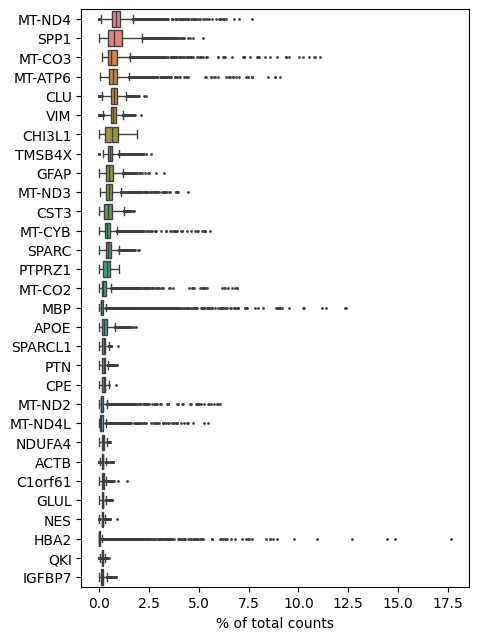

In [10]:
sc.pl.highest_expr_genes(adata)

## Spatial components

The new SOMA Experiment contains spatial data for this experiment stored in the spatial property of the Experiment. If we view the spatial collection we there is only one Scene named scene0.

In [11]:
scene = exp.spatial[scene_name]
scene

<Scene 'file:///home/jules/Software/TileDB-Inc/TileDB-SOMA/apis/python/notebooks/data/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/soma/spatial/scene1' (open for 'r') (3 items)
    'img': 'file:///home/jules/Software/TileDB-Inc/TileDB-SOMA/apis/python/notebooks/data/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/soma/spatial/scene1/img' (unopened)
    'obsl': 'file:///home/jules/Software/TileDB-Inc/TileDB-SOMA/apis/python/notebooks/data/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/soma/spatial/scene1/obsl' (unopened)
    'varl': 'file:///home/jules/Software/TileDB-Inc/TileDB-SOMA/apis/python/notebooks/data/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/soma/spatial/scene1/varl' (unopened)>

The scene contains three folders:

    img - A SOMA Collection that stores imagery data. In this example it contains an image pyramid for the high- and low-resolution slide.
    obsl - A SOMA Collection storing location data in the form of SOMADataFrames defined on the obs somajoinid (or obs_id). In this example, this contains a single dataframe with basic information about the Visium spot locations and sizes.
    varl - A collection that stores location data in form form of dataframes defined on the var somajoinid (or var_id). This collection is nested with the first layer mapping from measurement name to a collection storing dataframes. There is no feature spatial data in the Visium example, so this collection is empty.

Inside the img collection, there is a Image2DCollection storing the slide images. Here we view basic information about the slide zoom levels and read the data in the hires image.

The scene is defined on a pixel coordinate space.

In [12]:
scene.coordinate_space

CoordinateSpace(axes=(Axis(name='x', unit='pixels'), Axis(name='y', unit='pixels')))

## Images
Inside the `img` collection, there is a `MultiscaleImage` storing the slide images. Here we view basic information about the slide zoom levels and read the data in the `hires` image.

In [13]:
tissue_image = scene.img["tissue"]
tissue_image

<MultiscaleImage 'file:///home/jules/Software/TileDB-Inc/TileDB-SOMA/apis/python/notebooks/data/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/soma/spatial/scene1/img/tissue' (open for 'r')>

In [14]:
tissue_image.coordinate_space

CoordinateSpace(axes=(Axis(name='x', unit='pixels'), Axis(name='y', unit='pixels')))

Use the level_count property to get the number of levels in the `MultiscaleImage`.

In [15]:
tissue_image.level_count

2

Examine the metadata for each image level in the "tissue" collection.

In [16]:
for level in range(tissue_image.level_count):
    print(f"Level {level} shape: {tissue_image.level_shape(level)}")

Level 0 shape: (3, 2000, 1744)
Level 1 shape: (3, 600, 523)


Accessing individual elements of the `MultiscaleImage` collection returns a `DenseNDArray` that can be read using the standard API.

In [17]:
lowres = tissue_image["lowres"]
lowres

<DenseNDArray 'file:///home/jules/Software/TileDB-Inc/TileDB-SOMA/apis/python/notebooks/data/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/soma/spatial/scene1/img/tissue/lowres' (open for 'r')>

In [18]:
im = lowres.read().to_numpy()

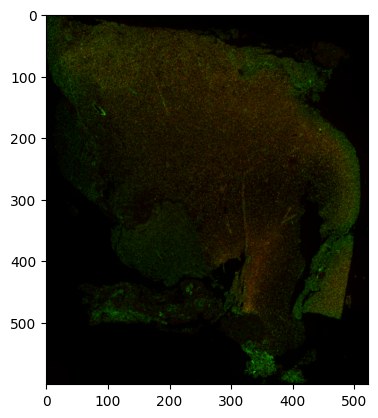

In [19]:
im = np.moveaxis(im, 0, -1).astype(np.uint8)  # Move channel axis to final axis for viewing.
plt.imshow(im)

## Spatial Dataframe
The `obsl` collection stores location data in the `loc` dataframe. This dataframes stores the spot locations of the Visium dataset with `soma_joinid` matching those used in the `obs` dataframe in the root `Experiment`.

In [20]:
spots_point_cloud = scene.obsl["loc"]

In [21]:
spots_point_cloud.coordinate_space

CoordinateSpace(axes=(Axis(name='x', unit='pixels'), Axis(name='y', unit='pixels')))

In [22]:
spots = spots_point_cloud.read().concat().to_pandas()
spots

,x,y,soma_joinid,in_tissue,array_row,array_col,spot_diameter_fullres
0,-87,3078,5436,1,26,182,184.593855
1,17,680,1735,1,17,181,184.593855
2,28,1212,1410,1,19,181,184.593855
3,39,1745,1337,1,21,181,184.593855
4,165,411,166,1,16,180,184.593855
...,...,...,...,...,...,...,...
5751,22616,22038,4115,1,99,37,184.593855
5752,22913,21500,5220,1,97,35,184.593855
5753,23231,22026,5016,1,99,33,184.593855
5754,22638,23103,2766,1,103,37,184.593855


In [23]:
obs_df = exp.obs.read().concat().to_pandas()
obs_df

,soma_joinid,obs_id
0,0,AACAATGGAACCACAT-1
1,1,AACAATGTGCTCCGAG-1
2,2,AACACCAGCCTACTCG-1
3,3,AACACCATTCGCATAC-1
4,4,AACACCGAATGTCTCA-1
...,...,...
5751,5751,TGTTGGCCTGTAGCGG-1
5752,5752,TGTTGGTGCGCACGAG-1
5753,5753,TGTTGGTGCGCTTCGC-1
5754,5754,TGTTGGTGCGGAATCA-1


In [24]:
joinid_counts = spots.soma_joinid.value_counts().value_counts()
assert len(joinid_counts) == 1
joinid_counts

count
1    5756
Name: count, dtype: int64

We take the data from the spot dataframe and create a plot showing the regions in the tissue.

In [25]:
radius = scene.obsl["loc"].metadata["soma_geometry"]
spot_patches = PatchCollection([
    mplp.Circle((row["x"], row["y"]), radius=radius, color='b')
    for _, row in spots.iterrows()
])

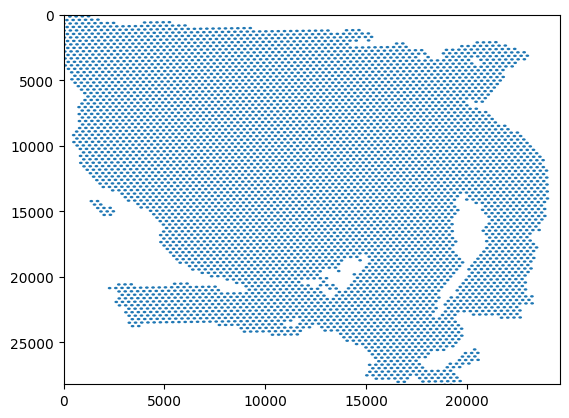

In [26]:
fig, ax = plt.subplots()
ax.set_xlim([0, 24592])
ax.set_ylim([0, 28202])
ax.invert_yaxis()
ax.add_collection(spot_patches)
plt.show()

Reading a region using coordinate transforms.

## Using Coordinate Spaces and Transforms
Coordinate spaces and coordinate transforms can be used to project both the Visium spots and the same image.

The scene allows us to check the coordinate spaces of individual elements.

In [27]:
scene.get_transform_to_multiscale_image("tissue")

<ScaleTransform
  input axes: ('x', 'y')
  output axes: ('x', 'y')
  scales: [0.07091737 0.07091696]>

In [28]:
scene.get_transform_to_multiscale_image("tissue", level=1)

<ScaleTransform
  input axes: ('x', 'y')
  output axes: ('x', 'y')
  scales: [0.02126708 0.02127509]>

In [29]:
scene.get_transform_to_point_cloud_dataframe("loc")

<IdentityTransform
  input axes: ('x', 'y')
  output axes: ('x', 'y')>

We want to take a piece of the region that both the multiscale image and point cloud are defined on to do the following:

* Read the region from the highest resolution level of the multiscale image.
* Read the region from the point cloud storing the spot locations.
* Use the transformation from the multiscale image to adjust and output of the point cloud and plot the two items together.

In [30]:
x_min, x_max = (0, 12000)
y_min, y_max = (14000, 24592)
fullres_region = [x_min, y_min, x_max, y_max]
fullres_to_image = scene.get_transform_to_multiscale_image("tissue")

In [31]:
hires_read = tissue_image.read_spatial_region(0,  fullres_region, region_transform=fullres_to_image)
hires_read

SpatialRead(data=<pyarrow.Tensor>
type: uint8
shape: (3, 753, 853)
strides: (642309, 853, 1), data_coordinate_space=CoordinateSpace(axes=(Axis(name='x', unit='pixels'), Axis(name='y', unit='pixels'))), output_coordinate_space=CoordinateSpace(axes=(Axis(name='x', unit=None), Axis(name='y', unit=None))), coordinate_transform=<AffineTransform
  input axes: ('x', 'y')
  output axes: ('x', 'y')
  augmented matrix:
    [[1.41009174e+01 0.00000000e+00 0.00000000e+00]
     [0.00000000e+00 1.41010000e+01 1.39881920e+04]
     [0.00000000e+00 0.00000000e+00 1.00000000e+00]]>)

In [32]:
hires_read.coordinate_transform.augmented_matrix

array([[1.41009174e+01, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.41010000e+01, 1.39881920e+04],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

We take the data from the spot dataframe, convert it to the hires resolution, and plot the two images together.

In [33]:
point_reader = scene.obsl["loc"].read_spatial_region(fullres_region)
point_reader

SpatialRead(data=<tiledbsoma._read_iters.TableReadIter object at 0xff6afc7015e0>, data_coordinate_space=CoordinateSpace(axes=(Axis(name='x', unit='pixels'), Axis(name='y', unit='pixels'))), output_coordinate_space=CoordinateSpace(axes=(Axis(name='x', unit='pixels'), Axis(name='y', unit='pixels'))), coordinate_transform=<IdentityTransform
  input axes: ('x', 'y')
  output axes: ('x', 'y')>)

In [34]:
spots = point_reader.data.concat().to_pandas()
spots

,x,y,soma_joinid,in_tissue,array_row,array_col,spot_diameter_fullres
0,1683,14221,1284,1,68,172,184.593855
1,1375,14227,3904,1,68,174,184.593855
2,1694,14753,1442,1,70,172,184.593855
3,1842,14484,3328,1,69,171,184.593855
4,2001,14747,3760,1,70,170,184.593855
...,...,...,...,...,...,...,...
923,11406,23069,5511,1,102,110,184.593855
924,11576,23864,4769,1,105,109,184.593855
925,11713,23063,5611,1,102,108,184.593855
926,11735,24127,4327,1,106,108,184.593855


In [35]:
spot_to_hires_matrix = hires_read.coordinate_transform.inverse_transform().augmented_matrix
spot_to_hires_matrix

array([[ 7.09173715e-02,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  7.09169562e-02, -9.92000000e+02],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [36]:
scale_x = spot_to_hires_matrix[0, 0]
scale_y = spot_to_hires_matrix[1, 1]
offset_x = spot_to_hires_matrix[0, 2]
offset_y = spot_to_hires_matrix[1, 2]

In [37]:
radius = scene.obsl["loc"].metadata["soma_geometry"]
spot_patches = PatchCollection([
    mplp.Ellipse(
        (scale_x * row["x"] + offset_x, scale_y * row["y"] + offset_y),
        width = radius * scale_x,
        height = radius * scale_y,
        fill=False,
        alpha=0.8,
    )
    for _, row in spots.iterrows()
])

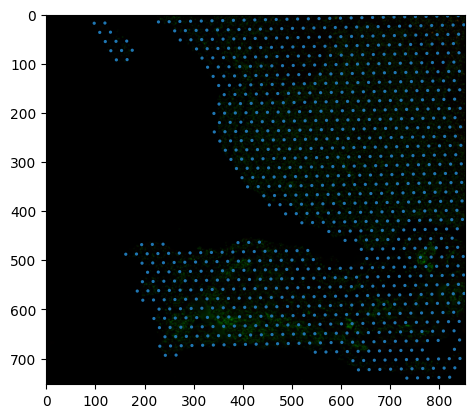

In [38]:
fig, ax = plt.subplots()
ax.imshow(np.moveaxis(hires_read.data, 0, -1).astype(np.uint8))
ax.add_collection(spot_patches)

plt.show()